## Part 1: Pulse Rate Algorithm

### Contents
Fill out this notebook as part of your final project submission.

**You will have to complete both the Code and Project Write-up sections.**
- The [Code](#Code) is where you will write a **pulse rate algorithm** and already includes the starter code.
   - Imports - These are the imports needed for Part 1 of the final project. 
     - [glob](https://docs.python.org/3/library/glob.html)
     - [numpy](https://numpy.org/)
     - [scipy](https://www.scipy.org/)
- The [Project Write-up](#Project-Write-up) to describe why you wrote the algorithm for the specific case.


### Dataset
You will be using the **Troika**[1] dataset to build your algorithm. Find the dataset under `datasets/troika/training_data`. The `README` in that folder will tell you how to interpret the data. The starter code contains a function to help load these files.

1. Zhilin Zhang, Zhouyue Pi, Benyuan Liu, ‘‘TROIKA: A General Framework for Heart Rate Monitoring Using Wrist-Type Photoplethysmographic Signals During Intensive Physical Exercise,’’IEEE Trans. on Biomedical Engineering, vol. 62, no. 2, pp. 522-531, February 2015. Link

-----

### Code

In [21]:
import glob

import numpy as np
import scipy as sp
import scipy.signal as signal
import scipy.io
import matplotlib.pyplot as plt


def LoadTroikaDataset():
    """
    Retrieve the .mat filenames for the troika dataset.

    Review the README in ./datasets/troika/ to understand the organization of the .mat files.

    Returns:
        data_fls: Names of the .mat files that contain signal data
        ref_fls: Names of the .mat files that contain reference data
        <data_fls> and <ref_fls> are ordered correspondingly, so that ref_fls[5] is the 
            reference data for data_fls[5], etc...
    """
    data_dir = "./datasets/troika/training_data"
    data_fls = sorted(glob.glob(data_dir + "/DATA_*.mat"))
    ref_fls = sorted(glob.glob(data_dir + "/REF_*.mat"))
    return data_fls, ref_fls

def LoadTroikaDataFile(data_fl):
    """
    Loads and extracts signals from a troika data file.

    Usage:
        data_fls, ref_fls = LoadTroikaDataset()
        ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])

    Args:
        data_fl: (str) filepath to a troika .mat file.

    Returns:
        numpy arrays for ppg, accx, accy, accz signals.
    """
    data = sp.io.loadmat(data_fl)['sig']
    return data[2:]

def AggregateErrorMetric(pr_errors, confidence_est):
    """
    Computes an aggregate error metric based on confidence estimates.

    Computes the MAE at 90% availability. 

    Args:
        pr_errors: a numpy array of errors between pulse rate estimates and corresponding 
            reference heart rates.
        confidence_est: a numpy array of confidence estimates for each pulse rate
            error.

    Returns:
        the MAE at 90% availability
    """
    # Higher confidence means a better estimate. The best 90% of the estimates
    #    are above the 10th percentile confidence.
    percentile90_confidence = np.percentile(confidence_est, 10)

    # Find the errors of the best pulse rate estimates
    best_estimates = pr_errors[confidence_est >= percentile90_confidence]

    # Return the mean absolute error
    return np.mean(np.abs(best_estimates))

def Evaluate():
    """
    Top-level function evaluation function.

    Runs the pulse rate algorithm on the Troika dataset and returns an aggregate error metric.

    Returns:
        Pulse rate error on the Troika dataset. See AggregateErrorMetric.
    """
    # Retrieve dataset files
    data_fls, ref_fls = LoadTroikaDataset()
    errs, confs = [], []
    ct = 1
    for data_fl, ref_fl in zip(data_fls, ref_fls):
        # Run the pulse rate algorithm on each trial in the dataset
        errors, confidence = RunPulseRateAlgorithm(data_fl, ref_fl, ct)
        errs.append(errors)
        confs.append(confidence)
        ct += 1
#         break
        # Compute aggregate error metric
    errs = np.hstack(errs)
    confs = np.hstack(confs)
    return AggregateErrorMetric(errs, confs)

## Defining few helper functions
def BPF(input_signal, fs=125):  
    """
    Band pass filter to pass 40-240BPM range
    Args:
        input_signal: numpy array of input signal to be filtered
        fs: sample rate
    Returns:
        Filtered input
    """
    
    b, a = signal.butter(5,(40/60, 240/60), btype='bandpass', fs=fs)
    return signal.filtfilt(b, a, input_signal)

def GetConfidence(near_freq, fft_sig):
    abs_sig = np.abs(fft_sig)
    # summing the frequency spectrum near the pulse rate estimate and dividing it by the sum of the entire spectrum.
    spec_sum = np.sum(abs_sig)
    if spec_sum == 0:
        spec_sum = 1
    val = np.sum(abs_sig[near_freq])/spec_sum
    return val

def RunPulseRateAlgorithm(data_fl, ref_fl, n):
    # Load data using LoadTroikaDataFile
    ppg, accx, accy, accz = LoadTroikaDataFile(data_fl)
    
    # Compute pulse rate estimates and estimation confidence.


    Fs = 125 # Sampling rate in README 125 Hz

    win_size = 8*Fs # Ground truth BPM provided in 8 second windows
    win_shift = 2*Fs # signals at 1st and 3rd positions i.e. gap of 2

    ref_data = sp.io.loadmat(ref_fl)['BPM0']
    L = len(ref_data)
    print("Length of Ref Data:", L)
    
    err = []
    conf = []
    ct = 0
    for idx in range(L):
        start = ct
        end = win_size + ct
        ct += win_shift

        # Get signals in this window frame
        wppg = ppg[start:end]
        waccx = accx[start:end]
        waccy = accy[start:end]
        waccz = accz[start:end]

        # Filter signals
        Fppg = BPF(wppg)
        Faccx = BPF(waccx)
        Faccy = BPF(waccy)
        Faccz = BPF(waccz)

#        # Combine Accelerometer Data
#         Fmean = np.mean(Faccy)
#         accy_mean = waccy - Fmean

#         acc_mag = np.sqrt(np.square(Faccx) + np.square(Faccy) + np.square(Faccz))
#         acc_mag = BPF(acc_mag)


        # Convert signals to Frequency domain
        freqs_ppg = np.fft.rfftfreq(len(Fppg), 1 / Fs) 
        bpf_freqs = (freqs_ppg >= (40/60)) & (freqs_ppg <= (240/60))
#         bpf_freqs = BPF(freqs_ppg)
        Bfreqs = freqs_ppg[bpf_freqs]

#         norm_ppg = (Fppg - np.mean(Fppg))/(max(Fppg)-min(Fppg))
        fft_ppg = np.fft.rfft(Fppg)#norm_ppg)
        fft_ppg_mag = np.abs(fft_ppg)[bpf_freqs]

        
        # Accelerometer
#         freqs = np.fft.rfftfreq(len(acc_mag), 1 / Fs) 
#         bpf_freqs = (freqs >= (40/60)) & (freqs <= (240/60))

#         norm_acc = (acc_mag - np.mean(acc_mag))/(max(acc_mag)-min(acc_mag))
#         fft_acc = np.fft.rfft(norm_acc)
#         fft_acc_mag = np.abs(fft_acc)[bpf_freqs]

        # ----X
        freqs = np.fft.rfftfreq(len(Faccx), 1 / Fs) 
        bpf_freqs = (freqs >= (40/60)) & (freqs <= (240/60))

#         norm_acc = (acc_mag - np.mean(acc_mag))/(max(acc_mag)-min(acc_mag))
        fft_accx = np.fft.rfft(Faccx)
        fft_accx_mag = np.abs(fft_accx)[bpf_freqs]
        
        # ---Y
#         freqs = np.fft.rfftfreq(len(acc_mag), 1 / Fs) 
#         bpf_freqs = (freqs >= (40/60)) & (freqs <= (240/60))

#         norm_acc = (acc_mag - np.mean(acc_mag))/(max(acc_mag)-min(acc_mag))
        fft_accy = np.fft.rfft(Faccy)
        fft_accy_mag = np.abs(fft_accy)[bpf_freqs]
        
        # ----Z
#         freqs = np.fft.rfftfreq(len(acc_mag), 1 / Fs) 
#         bpf_freqs = (freqs >= (40/60)) & (freqs <= (240/60))

#         norm_acc = (acc_mag - np.mean(acc_mag))/(max(acc_mag)-min(acc_mag))
        fft_accz = np.fft.rfft(Faccz)
        fft_accz_mag = np.abs(fft_accz)[bpf_freqs]

                
        # Find Peaks
        peaks_ppg = signal.find_peaks(fft_ppg_mag, height=5, distance=1)[0]
#         peaks_acc = signal.find_peaks(fft_acc_mag, height=10, distance=1)[0]
        
        peaks_accx = signal.find_peaks(fft_accx_mag, height=5, distance=1)[0]
        peaks_accy = signal.find_peaks(fft_accy_mag, height=5, distance=1)[0]
        peaks_accz = signal.find_peaks(fft_accz_mag, height=5, distance=1)[0]
        
        # Plot Signals
        if n == 1 and idx == 0:
            plt.figure()
#             plt.subplot(2, 2, 1)
            plt.plot(Fppg, color='red')
            plt.title("PPG Signal") 
#             plt.subplot(2, 2, 2)
            plt.figure()
            plt.plot(Faccx, color='blue')#acc_mag
            plt.plot(Faccy, color='red')
            plt.plot(Faccz, color='green')
            plt.legend(['AccX', 'AccY', 'AccZ'], loc='best')
            plt.title("Accelerometer Signal")
            plt.show()
            
            plt.figure()
#             plt.subplot(2, 2, 1)
            plt.plot(fft_ppg, color='red')
            plt.plot(peaks_ppg, fft_ppg_mag[peaks_ppg], 'x', color='yellow')
            plt.title("PPG Freq Signal") 
#             plt.subplot(2, 2, 2)
            plt.figure()
            plt.plot(fft_accx, color='blue')
            plt.plot(peaks_accx, fft_accx_mag[peaks_accx], 'x', color='yellow')
            plt.plot(fft_accy, color='red')
            plt.plot(peaks_accy, fft_accy_mag[peaks_accy], 'x', color='yellow')
            plt.plot(fft_accz, color='green')
            plt.plot(peaks_accz, fft_accz_mag[peaks_accz], 'x', color='yellow')
            plt.title("Accelerometer Freq Signal")
            plt.show()


        # Sort peaks 
        peaks_ppg = np.asarray(peaks_ppg)
#         peaks_acc = np.asarray(peaks_acc)
        sorted_peaks_ppg = np.sort(peaks_ppg)[::-1]
#         sorted_peaks_acc = np.sort(peaks_acc)[::-1]

        peaks_accx = np.asarray(peaks_accx)
        sorted_peaks_accx = np.sort(peaks_accx)[::-1]
        peaks_accy = np.asarray(peaks_accy)
        sorted_peaks_accy = np.sort(peaks_accy)[::-1]
        peaks_accz = np.asarray(peaks_accz)
        sorted_peaks_accz = np.sort(peaks_accz)[::-1]

        # Find Max Value from peaks for estimation
        ppg_max = sorted_peaks_ppg[0]

        for i in range(len(sorted_peaks_ppg)):
                ppg_max = sorted_peaks_ppg[i]
                if ppg_max in sorted_peaks_accx or ppg_max in sorted_peaks_accy or ppg_max in sorted_peaks_accz:
                    # consider another peak
                    continue
                else:
                    break

        res = Bfreqs[ppg_max]
        res_min = res*60
        nearby_freq = (freqs_ppg >= res - 40/60) & (freqs_ppg <= res + 40/60)
        cd = GetConfidence(nearby_freq, fft_ppg)
        
        GTBPM0 = ref_data[idx][0]
        
        err.append(res_min-GTBPM0)
        conf.append(cd)
        
        if idx == 0:
            print("Max PPG peak considered:", ppg_max)
            print("Max PPG freq considered:", res_min)
            print("Error:", res_min-GTBPM0, "\tConfidence:", cd)
            print("GT:", GTBPM0)
            print(sorted_peaks_ppg)
            print(sorted_peaks_accx)
            print(sorted_peaks_accy)
            print(sorted_peaks_accz)
    #         break

    errors, confidence = np.array(err), np.array(conf)
    return errors, confidence

Length of Ref Data: 148


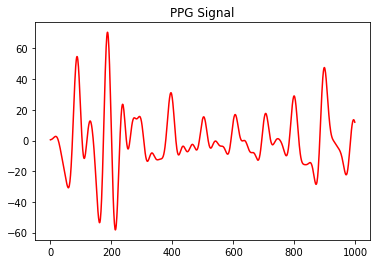

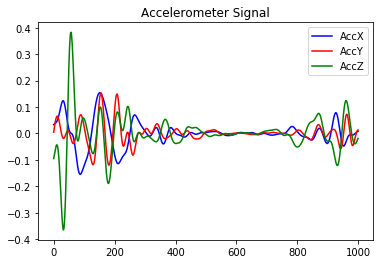

/opt/conda/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


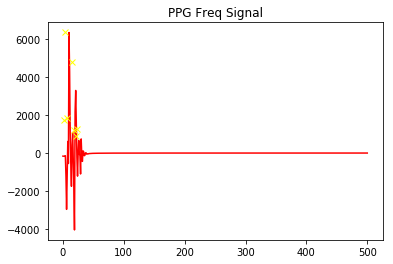

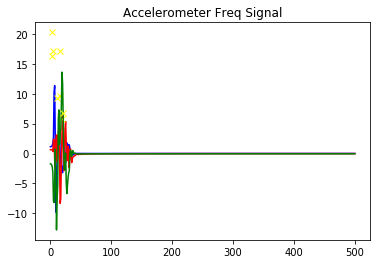

Max PPG peak considered: 23
Max PPG freq considered: 217.5
Error: 143.160792952 	Confidence: 0.138797834388
GT: 74.3392070485
[23 21 18 15  7  4  2]
[2]
[19 15 10]
[21 15  4  2]
Length of Ref Data: 148
Max PPG peak considered: 10
Max PPG freq considered: 120.0
Error: 35.2542372881 	Confidence: 0.412581095295
GT: 84.7457627119
[23 18 12 10  7  5  2]
[23 20 18 14 11  4  2]
[23 21 17 15 12  9  5  2]
[24 22 18 16 14 11  8  6  4  2]
Length of Ref Data: 140
Max PPG peak considered: 15
Max PPG freq considered: 157.5
Error: 53.4445 	Confidence: 0.362046877918
GT: 104.0555
[22 18 15 12  8  4  1]
[24 20 14 12 10  7  5  2]
[22 19 16 14 12  9  5  2]
[21 18 16 14 10  6  4  2]
Length of Ref Data: 107
Max PPG peak considered: 17
Max PPG freq considered: 172.5
Error: 89.627 	Confidence: 0.383282571403
GT: 82.873
[25 21 17 15 12  5  1]
[25 21 19 16 14 11  8  4  2]
[25 18 15 13 11  8]
[12  4  1]
Length of Ref Data: 146
Max PPG peak considered: 25
Max PPG freq considered: 232.5
Error: 149.6271 	Confidenc

In [22]:
mae = Evaluate()
print("MAE:", mae)

In [30]:
# checking data
data_fls, ref_fls = LoadTroikaDataset()
for data_fl, ref_fl in zip(data_fls, ref_fls):
    ppg, accx, accy, accz = LoadTroikaDataFile(data_fl)
    print(len(ppg), len(accx))
    print(accx)
    print(len(accy))
    print(len(accz))
    data = sp.io.loadmat(ref_fl)['BPM0']
    print(len(data), data[0][0])
    print(data)
    break

37937 37937
[-0.0702 -0.0702 -0.0546 ...,  0.4134  0.4134  0.4134]
37937
37937
148 74.3392070485
[[  74.33920705]
 [  76.35746606]
 [  77.14285714]
 [  74.66814159]
 [  72.58064516]
 [  71.68458781]
 [  72.89416847]
 [  73.44940152]
 [  75.33482143]
 [  76.8442623 ]
 [  79.5990566 ]
 [  79.11392405]
 [  74.50331126]
 [  70.83825266]
 [  69.58762887]
 [  71.94244604]
 [  77.31958763]
 [  80.29978587]
 [  82.87292818]
 [  83.51893096]
 [  84.65011287]
 [  88.23529412]
 [  90.95920617]
 [  92.87925697]
 [  94.73684211]
 [  97.28773585]
 [  99.66777409]
 [ 101.58013544]
 [ 102.84810127]
 [ 103.44827586]
 [ 103.17460317]
 [ 102.95670539]
 [ 103.28389831]
 [ 104.05549626]
 [ 106.20915033]
 [ 108.58324716]
 [ 110.66969353]
 [ 111.58342189]
 [ 112.29946524]
 [ 112.78195489]
 [ 113.63636364]
 [ 114.50381679]
 [ 115.13157895]
 [ 116.02209945]
 [ 117.05685619]
 [ 118.54583772]
 [ 120.19230769]
 [ 121.8851571 ]
 [ 123.96694215]
 [ 125.78616352]
 [ 128.06830309]
 [ 130.86150491]
 [ 133.18534961]
 [

-----
### Project Write-up

Answer the following prompts to demonstrate understanding of the algorithm you wrote for this specific context.

> - **Code Description** - Include details so someone unfamiliar with your project will know how to run your code and use your algorithm. 
> - **Data Description** - Describe the dataset that was used to train and test the algorithm. Include its short-comings and what data would be required to build a more complete dataset.
> - **Algorithhm Description** will include the following:
>   - how the algorithm works
>   - the specific aspects of the physiology that it takes advantage of
>   - a describtion of the algorithm outputs
>   - caveats on algorithm outputs 
>   - common failure modes
> - **Algorithm Performance** - Detail how performance was computed (eg. using cross-validation or train-test split) and what metrics were optimized for. Include error metrics that would be relevant to users of your algorithm. Caveat your performance numbers by acknowledging how generalizable they may or may not be on different datasets.

Your write-up goes here...

-----
### Next Steps
You will now go to **Test Your Algorithm** to apply a unit test to confirm that your algorithm met the success criteria. 